In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else torch.device("mps"))
print(f"Using device: {device}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Using device: mps


In [4]:
# Load dataset
data_dir = "./dataset"
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=transform)

Class mapping: {'paper': 0, 'rock': 1, 'scissor': 2, 'unknown': 3}
Epoch 1/10, Train Loss: 0.3203, Val Loss: 0.1617
Epoch 2/10, Train Loss: 0.0068, Val Loss: 0.0397
Epoch 3/10, Train Loss: 0.0046, Val Loss: 0.1180
Epoch 4/10, Train Loss: 0.0026, Val Loss: 0.0504
Epoch 5/10, Train Loss: 0.0075, Val Loss: 0.0299
Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0378
Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0396
Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0415
Epoch 9/10, Train Loss: 0.0000, Val Loss: 0.0428
Epoch 10/10, Train Loss: 0.0000, Val Loss: 0.0408


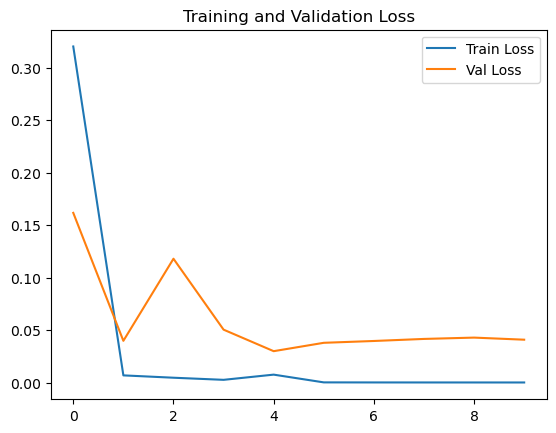

Model saved as rps_model.pth


In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print class mapping
print("Class mapping:", train_dataset.class_to_idx)

# Define CNN Model
class RockPaperScissorsCNN(nn.Module):
    def __init__(self):
        super(RockPaperScissorsCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 output classes: rock, paper, scissors, unknown  
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = RockPaperScissorsCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Plot training and validation loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

# Save the trained model
torch.save(model.state_dict(), "rps_model.pth")
print("Model saved as rps_model.pth")